
<span style="font-size:40px;">Aesthetics exploration based on wiki data</span>

### Links:

* [Our website](https://antekskrobisz.wixsite.com/my-site-1)
* [Aesthetics Fandom](https://aesthetics.fandom.com/wiki/Aesthetics_Wiki)
* [Dataset](xxx)


# Motivation

### The dataset

We've found a Fandom page dedicated to aesthetics (see the link above), which describes more than 549 different aesthetics! We scraped a list of them from the website and downloaded all the descriptions with an intention and hope to draw some interesting insights into this fascinating topic.

Aesethetics are represented as nodes of our network. For each node we have a raw file with the Wiki description, as well as a clean file with the content of the page.

### 1.2. Why?

During the first session on this project we were trying to find something that we all are interested in. After searching for interesting Wiki pages we ended up with two best opstions. One of them was a Fandom dedicated to food. Lovely topic, yet already explored thoroughly. The second option was aesthetics related Fandom. We loved the idea of exploring aesthetics dataset right away. It had enough nodes, user defined related sites and most importantly, very extensive descriptions that would allow us to perform amazing text analysis.

### 1.3. Our goal

Our goal was to explore the resulting network and draw some conclusions regarding relations between different aesthetics. It seems right to refer to aesthetics definitions here, which is "the formal study of art, especially in relation to the idea of beauty". The biggest challenge of our project is that barely any people understand our nodes so we have to be very careful about delivering the right information.

This matter is undeniably present in everybody's life, even if it is not necessarily the object of one's continuous attention. It just seems very obvious to us to jugde whether we find something beautiful or not. However, we don't really spend time to understand different points of view of the beauty itself.

Thereby, we intend to delivere to our end user a comprehensible way of exploring aesthetics and relations between them, as well as provide some insight into this topic.

# Getting ready for the analyses & Basic stats

If you downloaded all of the data from our GitHub run the imports section and start from "Load pre-downloaded".

## Data preprocessing

First of all, we used Fandom API to download the page containing full list of aesthetics. Then using regular expressions we extracted all the aesthetics names. We noticed, that some of them contain alternative names, therefore we used **split** to overcome this issue. We also noticed some inaccuracies between the names in the list of aesthetics and the names of their pages, so we relabeled relevant nodes.

The working code is presented below:

But first, imports (including those for analyses) :)

In [272]:
import urllib.request
import json
import re
import nltk
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.corpus import PlaintextCorpusReader
from nltk.book import FreqDist
import os
import community.community_louvain as community_louvain
import math
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from matplotlib import pyplot as plt
import requests
import scipy.stats as stats
import powerlaw
# from fa2 import ForceAtlas2
from nltk.tokenize import WordPunctTokenizer
from bokeh.io import output_file, show, output_notebook, reset_output
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool, WheelZoomTool, PanTool, TapTool , MultiLine, NodesAndLinkedEdges, EdgesAndLinkedNodes)
from bokeh.palettes import Spectral4, Turbo256
from bokeh.plotting import from_networkx
from bokeh.transform import linear_cmap
from bokeh.models import Panel, Tabs

from bokeh.models import ColumnDataSource, CategoricalColorMapper, Label
from bokeh.palettes import RdBu3, Category20, Spectral, Spectral11, Category10
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.layouts import column, row
from bokeh.io import save

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from operator import itemgetter, attrgetter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statistics
import matplotlib.pyplot as plt
import json

import seaborn as sns

output_notebook() # set bokeh output to display in the notebook
sns.set_style("white") # set seaborn theme
%matplotlib inline  

Loading BokehJS ...

Now it's time to extract the list of aesthetics with relevant regex

In [ ]:
baseurl = "https://aesthetics.fandom.com/api.php?"
action = "action=query"
title = "List_of_Aesthetics"
content = "prop=revisions&rvprop=content&rvslots=*" 
dataformat = "format=json" 

query = baseurl+action+"&"+content+"&titles="+title+"&"+dataformat
response = urllib.request.urlopen(query)
data = response.read()
cont = data.decode('utf-8')
jsontext = json.loads(cont)

en_pag=re.findall(r'\d+',str(jsontext['query']['pages'].keys()))
txt_new=jsontext['query']['pages'][str(en_pag[0])]['revisions'][0]['slots']['main']['*']

pattern="(?:\[\[(.*?)\]\])"
alph_txt=re.split('(?:\=\=A\=\=)', txt_new)
alph_list=re.findall(pattern, alph_txt[1])

In [ ]:
DG = nx.DiGraph()

for i in alph_list:
    if "|" in i:
        spl=re.split('(?:\|)', i)
        alph_list[alph_list.index(i)]=spl[1]
        DG.add_node(spl[1])    
    else:
        DG.add_node(i)

Below, we use a mapping for aesthetics scraped from a list that didn't match their site name.

In [ ]:
mapping = {'Neo - Romanism':'Neo-Romanism', 'Robotics Kid':'Robotics Kids', 'Sad people':'Sadpeople', 
           'Arts and Crafts':'Arts and Crafts Movement','Junkpunk':'Salvagepunk','Natural Philosophy':'Green_Academia',
          'Spy fiction':'Spy_Fiction','Shā mǎ tè':'Shamate','Woodland Goth':'Woodland_goth','Ms Paint':'MS Paint'}
DG = nx.relabel_nodes(DG, mapping)

Let's save the list for later use

In [ ]:
pd.DataFrame(list(DG.nodes())).to_csv('aesthetics.csv')

Downloading a raw document for each of the aesthetics.

In [ ]:
for char in DG:
    address = 'https://aesthetics.fandom.com/api.php?'
    action="action=query"
    titles=f"titles={char}"
    content="prop=revisions&rvslots=*&rvprop=content"
    dataformat="format=json"
    query = '%s%s&%s&%s&%s' % (address, action, titles, content, dataformat)
    response = requests.get(query)
    content_char = response.text
    char_file = char.replace('/','_')
    with open('aesthetics/'+f'{char_file}.txt', 'w') as f:
        f.write(content_char)

Let's add the connections to our network we used this regex to do so:
 - ````(?<=\[\[).*?(?=\]\])```` 
     - ````(?<=\[\[)```` - positive lookbehind of double squared brackets (looks for '\[\[' but does not include it in the match)
     - ````.*?```` - matches any character any number of times but as few times as possible
     - ````(?=\]\])```` - positive lookahead of double squared brackets (looks for '\]\]' but does not include it in the match)

In [ ]:
for char in DG:
    char_file = char.replace('/','_')
    with open('aesthetics/'+f'{char_file}.txt', 'r') as f:
        a = f.read().replace('\n', '')
        pol = list(set(re.findall(r'\[\[([\w\s]*).*?\]\]', a)))
    table = str(re.findall(r'(?<=\{\{).*?(?=\}\})', a))

    
    connections = [x for x in list(set(re.findall(r'(?<=\[\[).*?(?=\]\])', table))) if x in DG]
    
    for c in connections:
        DG.add_edge(char, c )

The code below downloads the clean verion of the descriptions:

In [ ]:
baseurl = "https://aesthetics.fandom.com/api.php?"
action = "action=query"
content = "prop=extracts&exlimit=1&explaintext"
dataformat ="format=json"
tk = WordPunctTokenizer()

for file in DG:
    
    if file == "Mindcore":
        print(" ")
    else:
        char_file = file.replace('/','_')
        title = "titles="+urllib.parse.quote_plus(file)
        query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
        wikiresponse = urllib.request.urlopen(query)
        wikidata = wikiresponse.read()
        wikitext = wikidata.decode('utf-8')

        pag_val=re.findall(r'\d+',str(json.loads(wikitext)['query']['pages'].keys()))

        clean = json.loads(wikitext)['query']['pages'][pag_val[0]]['extract']
        clean = re.sub('=+.*?=+','',re.sub('=+ Gallery.*','', re.sub('\t','',re.sub('\n','', clean))))

        ftk = tk.tokenize(clean.lower())

        ftk =[ tok for tok in ftk if tok.isalpha()]
        if file == "Coffee House/Cafe":
            char_file='Coffee House_Cafe'
        with open('clean/'+f'{char_file}.txt', 'w',encoding="utf-8") as f:
            f.write(' '.join([str(item) for item in ftk]))
    

This one downloads and tokenizes the descriptions:

In [ ]:
#without stopwords
from gensim.parsing.preprocessing import remove_stopwords
from nltk.corpus import stopwords

baseurl = "https://aesthetics.fandom.com/api.php?"
action = "action=query"
content = "prop=extracts&exlimit=1&explaintext"
dataformat ="format=json"
tk = WordPunctTokenizer()

for file in DG:
    
    if file == "Mindcore":
        print(" ")
    else:
        char_file = file.replace('/','_')
        title = "titles="+urllib.parse.quote_plus(file)
        query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
        wikiresponse = urllib.request.urlopen(query)
        wikidata = wikiresponse.read()
        wikitext = wikidata.decode('utf-8')

        pag_val=re.findall(r'\d+',str(json.loads(wikitext)['query']['pages'].keys()))

        clean = json.loads(wikitext)['query']['pages'][pag_val[0]]['extract']
        clean = re.sub('=+.*?=+','',re.sub('=+ Gallery.*','', re.sub('\t','',re.sub('\n','', clean))))

        ftk = tk.tokenize(clean.lower())

        ftk =[ tok for tok in ftk if tok.isalpha()]

        ftk = [tok for tok in ftk if not tok in stopwords.words()]

        with open('cleaner/'+f'{char_file}.txt', 'w',encoding="utf-8") as f:
            f.write(' '.join([str(item) for item in ftk]))
    

And finally the code that downloads just the first part od the description, that well then use for text summarization:

In [ ]:
baseurl = "https://aesthetics.fandom.com/api.php?"
action = "action=query"
content = "prop=extracts&exlimit=1&explaintext"
dataformat ="format=json"
tk = WordPunctTokenizer()
check=['Junkpunk', 'Natural Philosophy', 'Shā mǎ tè', 'Spy fiction', 'Woodland Goth']
for file in DG:
    if file == "Mindcore":
        continue
    elif file in check:
        if file == 'Junkpunk':
            file='Salvagepunk'
        if file == 'Natural Philosophy':
            file='Green_Academia'
        if file == 'Spy fiction':
            file='Spy_Fiction'
        if file == 'Shā mǎ tè':
            file='Shamate'
        if file == 'Woodland Goth':
            file='Woodland_goth'
    else:
        char_file = file.replace('/','_')
        title = "titles="+urllib.parse.quote_plus(file)
        query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
        wikiresponse = urllib.request.urlopen(query)
        wikidata = wikiresponse.read()
        wikitext = wikidata.decode('utf-8')

        pag_val=re.findall(r'\d+',str(json.loads(wikitext)['query']['pages'].keys()))

        clean = json.loads(wikitext)['query']['pages'][pag_val[0]]['extract']
        clean = re.split('=+.*?=+',clean)
        clean = [re.sub('\n','', i) for i in clean[0]]


        clean = ''.join(map(str, clean))
        with open('text_analysis/'+f'{char_file}.txt', 'w',encoding="utf-8") as f:
            f.write(clean)

### Load pre-downloaded

Load aesthetics list

In [5]:
with open('aesthetics.txt', 'r',encoding="utf-8") as f:
    txt_new=f.read()

Extract related aesthetics

In [6]:
pattern="(?:\[\[(.*?)\]\])"

alph_txt=re.split('(?:\=\=A\=\=)', txt_new)

In [7]:
alph_list=re.findall(pattern, alph_txt[1])

Add nodes to the graph

In [8]:
DG = nx.DiGraph()

for i in alph_list:
    if "|" in i:
        spl=re.split('(?:\|)', i)
        alph_list[alph_list.index(i)]=spl[1]
        DG.add_node(spl[1])    
    else:
        DG.add_node(i)

Map problematic nodes

In [9]:
mapping = {'Neo - Romanism':'Neo-Romanism', 'Robotics Kid':'Robotics Kids', 'Sad people':'Sadpeople', 
           'Arts and Crafts':'Arts and Crafts Movement','Junkpunk':'Salvagepunk','Natural Philosophy':'Green_Academia',
          'Spy fiction':'Spy_Fiction','Shā mǎ tè':'Shamate','Woodland Goth':'Woodland_goth','Ms Paint':'MS Paint'}
DG = nx.relabel_nodes(DG, mapping)

Calculate number of characters in the content

In [10]:
loc={}
for char in DG:
    char_file = char.replace('/','_')
    with open('aesthetics/'+f'{char_file}.txt', 'r') as f:
        a = f.read()
        loc[char] = {'loc':len(re.findall(r'\w+', a))}

Add edges to the graph

In [11]:
egdes={}
for char in DG:
    char_file = char.replace('/','_')
    with open('aesthetics/'+f'{char_file}.txt', 'r') as f:
        a = f.read().replace('\n', '')
        pol = list(set(re.findall(r'\[\[([\w\s]*).*?\]\]', a)))
    table = str(re.findall(r'(?<=\{\{).*?(?=\}\})', a))

    
    connections = [x for x in list(set(re.findall(r'(?<=\[\[).*?(?=\]\])', table))) if x in DG]
    
    for c in connections:
        DG.add_edge(char, c )

Load text summaries. The exact method of extracting them is described in the "Advanced text analysis section" of the notebook.

In [12]:
summaries={}
for char in DG:
    char_file = char.replace('/','_')
    with open('text_sum/'+f'{char_file}.txt', 'r', encoding='utf8') as f:
        a = f.read()
    summaries[char] = {'summary':a}

## Basic stats

Calculate the degree and extract the GCC and undirected representation of GCC

In [29]:
# extraction of GCC and creation of the undirected version of the graph
largest_cc = max(nx.weakly_connected_components(DG), key=len)
DGCC = DG.subgraph(largest_cc)
UGCC = DGCC.to_undirected()
d = dict(DGCC.degree)

## Number of nodes

In [16]:
print(f'Number of nodes: {len(DG.nodes)}')
print(f'Number of nodes in the giant connected component: {len(DGCC.nodes)}')
print(f'Number of nodes not connected to the GCC: {len(DG.nodes-DGCC.nodes)}')

Number of nodes: 549
Number of nodes in the giant connected component: 517
Number of nodes not connected to the GCC: 32


We use the method of extracting a giant connected component to see wether the Aesthetics Wiki is a connected structure.
We can see that only 32 nodes are not included in the GCC from almost 550 of total nodes.

## Number of edges

In [17]:
print(f'Number of edges: {len(DG.edges)}')
print(f'Number of edges in the giant connected component: {len(DGCC.edges)}')
print(f'Number of edges in the undirected representation of GCC: {len(UGCC.edges)}')

Number of edges: 3301
Number of edges in the giant connected component: 3298
Number of edges in the undirected representation of GCC: 2552


The edges are based on users' inputs to the section "Related Aesthetics". We can see that we have over 3 thousand edges just by extracting this field from Wiki Pages.

## Distributions of content length

In [18]:
# Set the attributes for analyses
nx.set_node_attributes(DGCC, loc)
nx.set_node_attributes(UGCC, loc)

We put the analysis of content length at the beginning of our notebook as a large part of our project was related to text analyses. Below we can see that we have an average length of content of 860 characters and no empty descriptions. It gives us a good starting point for advanced text analyses. 

In [19]:
loc_list = [DGCC.nodes[node]['loc'] for node in DGCC.nodes]
print(f'Average length of page content: {np.mean(loc_list)} characters')
print(f'Maximum length of page content: {np.max(loc_list)} characters')
print(f'Minimum length of page content: {np.min(loc_list)} characters')

Average length of page content: 859.8046421663443 characters
Maximum length of page content: 7910 characters
Minimum length of page content: 14 characters


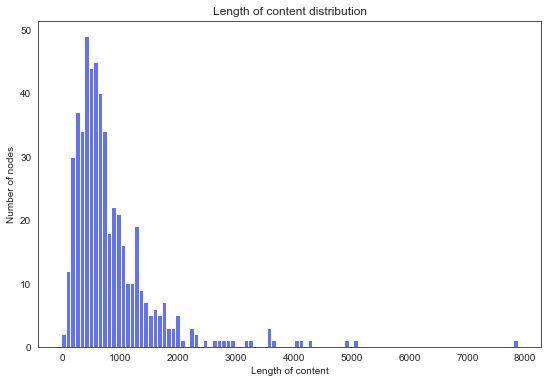

In [20]:
plt.rcParams["figure.figsize"] = (9,6) # set default figure size
counts, edges = np.histogram(loc_list, bins = 100)
plt.bar(edges[:-1], counts, width=np.diff(edges), color='#6171FF')
plt.title("Length of content distribution")
plt.xlabel('Length of content')
plt.ylabel('Number of nodes')
plt.show()

We can see that the distribution of this attribute has most of the nodes around the mean and several descriptions with a very large length.

## Degree Distributions

To better understand the structure of our graph and especially the connections between the nodes we use degree distributions 
analysis. Below we can see distributions and log distributions for in and out degrees in the directed graph and 
for the undirected representation of the graph. We see a distribution similar to scale free networks for the in-degrees and
distributions more similar to random networks for out-degrees and undirected graph. We analyze them mathematically by using powerlaw to define their related network regime. 


C:\Users\bgran\AppData\Local\Temp/ipykernel_18996/567327499.py:14: RuntimeWarning: divide by zero encountered in log
  axs[0, 1].scatter(np.log(edges[:-1]), np.log(counts), color='#6171FF')
C:\Users\bgran\AppData\Local\Temp/ipykernel_18996/567327499.py:29: RuntimeWarning: divide by zero encountered in log
  axs[1, 1].scatter(np.log(edges[:-1]), np.log(counts), color='#6171FF')


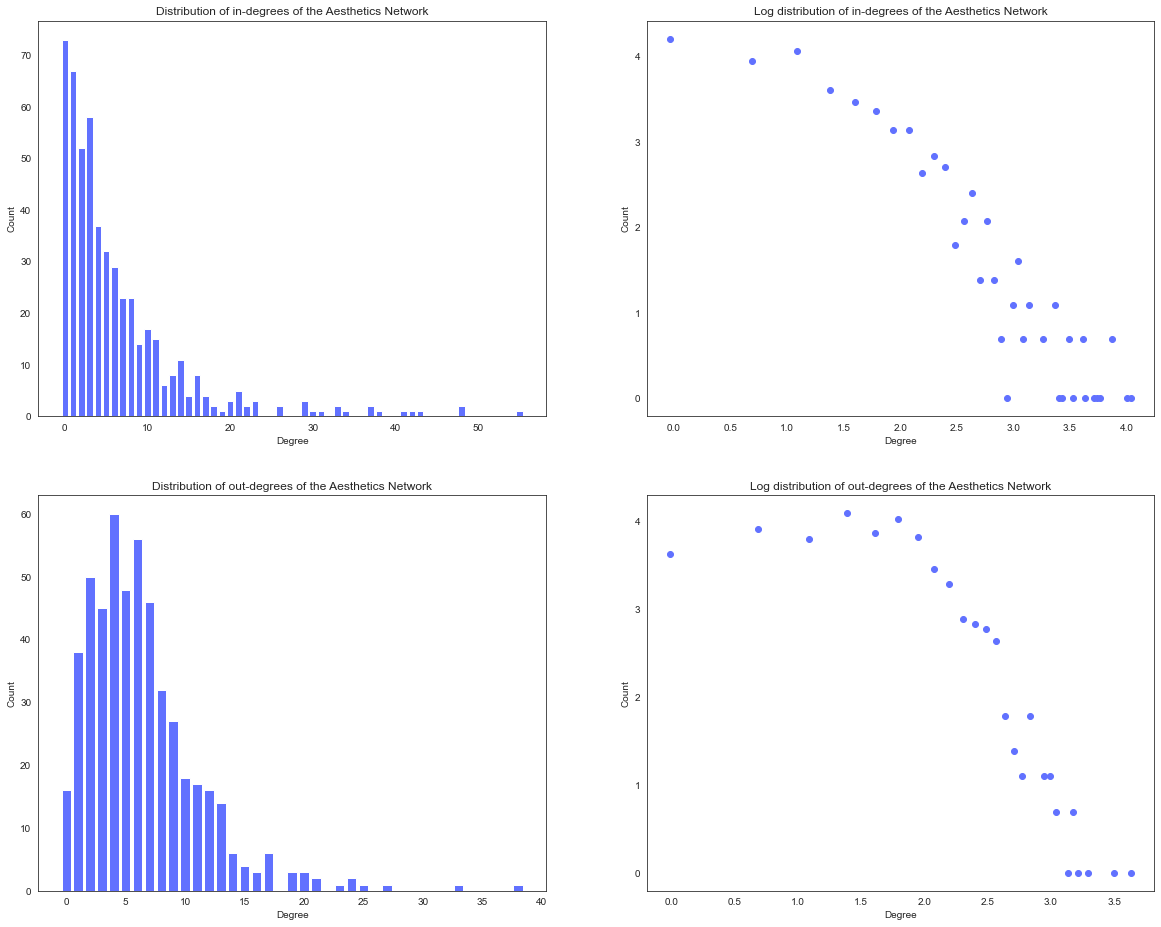

In [21]:
# directed in degrees
fig, axs = plt.subplots(2, 2, figsize = (20,16))

d_in=dict(DGCC.in_degree())
#Bar plot of the in-degree distribution
in_degrees=list(d_in.values())
v1 = np.arange(int(min(in_degrees)),int(max(in_degrees)))
count,bins=np.histogram(in_degrees,bins=v1)
axs[0, 0].bar(bins[:-1], count, color='#6171FF')
axs[0, 0].set_title('Distribution of in-degrees of the Aesthetics Network')

x = [val for (node, val) in DGCC.in_degree()]
counts, edges = np.histogram(x, bins = 1000)
axs[0, 1].scatter(np.log(edges[:-1]), np.log(counts), color='#6171FF')
axs[0, 1].set_title('Log distribution of in-degrees of the Aesthetics Network')


# directed out degrees
d_out=dict(DGCC.out_degree())
#Bar plot of the out-degree distribution
out_degrees=list(d_out.values())
v2 = np.arange(int(min(out_degrees)),int(max(out_degrees))+2)
count,bins=np.histogram(out_degrees,bins=v2)
axs[1, 0].bar(bins[:-1], count, color='#6171FF')
axs[1, 0].set_title('Distribution of out-degrees of the Aesthetics Network')

x = [val for (node, val) in DGCC.out_degree()]
counts, edges = np.histogram(x, bins = 1000)
axs[1, 1].scatter(np.log(edges[:-1]), np.log(counts), color='#6171FF')
axs[1, 1].set_title('Log distribution of out-degrees of the Aesthetics Network')

for ax in axs.flat:
    ax.set(xlabel='Degree', ylabel='Count')

    
plt.show()

C:\Users\bgran\AppData\Local\Temp/ipykernel_18996/385187493.py:14: RuntimeWarning: divide by zero encountered in log
  axs[1].scatter(np.log(edges[:-1]), np.log(counts), color='#6171FF')


Text(0.5, 1.0, 'Log distribution of degrees of the undirected representation')

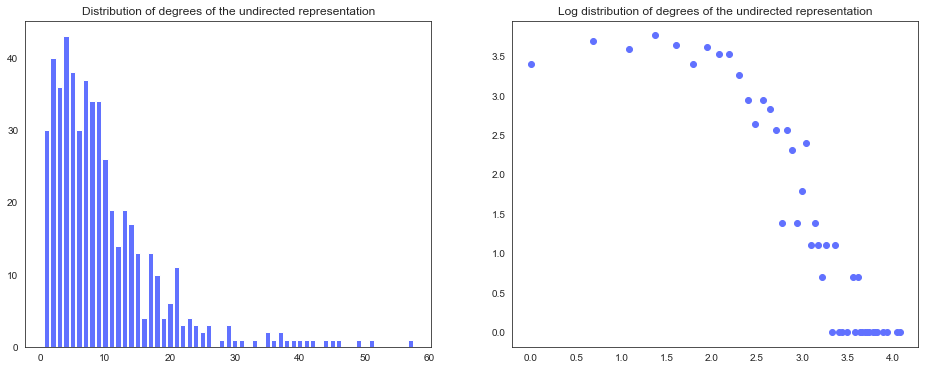

In [22]:
# undirected degrees
fig, axs = plt.subplots(1, 2, figsize = (16,6))

d_in=dict(UGCC.degree())
#Bar plot of the in-degree distribution
in_degrees=list(d_in.values())
v1 = np.arange(int(min(in_degrees)),int(max(in_degrees)))
count,bins=np.histogram(in_degrees,bins=v1)
axs[0].bar(bins[:-1], count, color='#6171FF')
axs[0].set_title('Distribution of degrees of the undirected representation')

x = [val for (node, val) in UGCC.degree()]
counts, edges = np.histogram(x, bins = 1000)
axs[1].scatter(np.log(edges[:-1]), np.log(counts), color='#6171FF')
axs[1].set_title('Log distribution of degrees of the undirected representation')

### Exponent of the degree distribution

By using powerlaw we achieve a confirmation of our hypothesis based on the distribution graphs. In-degrees represent 
a distribution almost in the scale-free regime while out-degrees and undirected graph degrees have distributions
characteristic for networks in the random network regime.

In [32]:
# fit powerlaw for in degrees
deg_list_all_in = [val for (node, val) in DGCC.in_degree()]
powerlaw.Fit(deg_list_all_in).alpha

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


3.0451862320973295

In [33]:
# fit powerlaw for out degrees
deg_list_all_out = [val for (node, val) in DGCC.out_degree()]
powerlaw.Fit(deg_list_all_out).alpha

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


4.814267246186508

In [34]:
# fit powerlaw for undirected representation
deg_list_ugcc = [val for (node, val) in UGCC.degree()]
powerlaw.Fit(deg_list_ugcc).alpha

Calculating best minimal value for power law fit


3.8750743157252994

# 3. Tools, theory and analysis 

In this part we present all of the analyses performed throughout the project, even if they are not present on the website. 
We try to elaborate on theory and used tools and also to justify our choices.

## Graph analysis

First we looked at more complex statistics for our networks to get a better overview of different properties.
Once again we see that in-degrees have higher maximum values resulting in more scale-free-like distribution of degrees. Also the median is lower than the  

### Advanced stats

In [31]:
# in degrees
print(f'average degree: {np.mean(deg_list_all_in)}')
print(f'median of the degree: { np.median(deg_list_all_in)}')
print(f'mode of the degree: { stats.mode(deg_list_all_in)}')
print(f'min of the degree: { np.min(deg_list_all_in)}')
print(f'max of the degree: {np.max(deg_list_all_in)}')

average degree: 6.379110251450677
median of the degree: 4.0
mode of the degree: ModeResult(mode=array([0]), count=array([73]))
min of the degree: 0
max of the degree: 57


In [36]:
# in degrees
print(f'average degree: {np.mean(deg_list_all_out)}')
print(f'median of the degree: { np.median(deg_list_all_out)}')
print(f'mode of the degree: { stats.mode(deg_list_all_out)}')
print(f'min of the degree: { np.min(deg_list_all_out)}')
print(f'max of the degree: {np.max(deg_list_all_out)}')

average degree: 6.379110251450677
median of the degree: 6.0
mode of the degree: ModeResult(mode=array([4]), count=array([60]))
min of the degree: 0
max of the degree: 38


In [37]:
# in degrees
print(f'average degree: {np.mean(deg_list_ugcc)}')
print(f'median of the degree: { np.median(deg_list_ugcc)}')
print(f'mode of the degree: { stats.mode(deg_list_ugcc)}')
print(f'min of the degree: { np.min(deg_list_ugcc)}')
print(f'max of the degree: {np.max(deg_list_ugcc)}')

average degree: 9.872340425531915
median of the degree: 8.0
mode of the degree: ModeResult(mode=array([4]), count=array([43]))
min of the degree: 1
max of the degree: 59


### Top connected nodes

In this section we look at the top connected nodes.

In [38]:
# Top 5 most connected aesthetics in terms of in degree
sorted([
    {'name':x, 'value':DGCC.in_degree(x)} 
    for x,y in DGCC.nodes(data=True) 
], key=lambda k: k['value'],reverse=True)[0:10]

[{'name': 'Cottagecore', 'value': 57},
 {'name': 'Vaporwave', 'value': 55},
 {'name': 'Naturecore', 'value': 48},
 {'name': 'Vintage', 'value': 48},
 {'name': 'Dark Academia', 'value': 43},
 {'name': 'Cyberpunk', 'value': 42},
 {'name': 'Art Academia', 'value': 41},
 {'name': 'Pastel', 'value': 38},
 {'name': 'Goth', 'value': 37},
 {'name': 'Kidcore', 'value': 37}]

In [39]:
# Top 5 most connected aesthetics in terms of in degree
sorted([
    {'name':x, 'value':DGCC.out_degree(x)} 
    for x,y in DGCC.nodes(data=True) 
], key=lambda k: k['value'],reverse=True)[0:10]


[{'name': 'Milleniwave', 'value': 38},
 {'name': 'Cyberpunk', 'value': 33},
 {'name': 'Lo-Fi', 'value': 27},
 {'name': 'Witchcore', 'value': 25},
 {'name': 'Cottagecore', 'value': 24},
 {'name': 'Neo-Romanism', 'value': 24},
 {'name': 'Glowwave', 'value': 23},
 {'name': 'Rainbowcore', 'value': 21},
 {'name': 'Vaporwave', 'value': 21},
 {'name': 'Camp', 'value': 20}]

In [40]:
# Top 5 most connected aesthetics undirected representation
sorted([
    {'name':x, 'value':UGCC.degree(x)} 
    for x,y in UGCC.nodes(data=True) 
], key=lambda k: k['value'],reverse=True)[0:10]

[{'name': 'Cottagecore', 'value': 59},
 {'name': 'Vaporwave', 'value': 57},
 {'name': 'Vintage', 'value': 51},
 {'name': 'Naturecore', 'value': 49},
 {'name': 'Cyberpunk', 'value': 46},
 {'name': 'Dark Academia', 'value': 45},
 {'name': 'Art Academia', 'value': 44},
 {'name': 'Lo-Fi', 'value': 42},
 {'name': 'Milleniwave', 'value': 41},
 {'name': 'Pastel', 'value': 40}]

We can see interesting results. We were expecting aesthetics most common to us like goth and punk to be the most connected ones. 
However, for both in degrees and undirected representation the most connected node is Cottagecore. It turns out that there is a very
large number of related aesthetics that refer to rural areas and nature (more insights into meaning of aesthetics later). In general the most connected nodes are the one that 
are very general like Naturecore (everything related to neture can be related) or popular ones like Cyberpunk or Vaporwave.

### Node centrality

After evaluating the most important nodes in terms of degrees we look at assesing the importance by using different measures 
of node centrality and the PageRank algorithm. We use different algorithms to find out if there are nodes that might be 
central but do not have very high number of connections.

In [43]:
# degree centrality
sorted([{'name':x, 'value':y} for x,y in nx.degree_centrality(UGCC).items()], key=lambda k: k['value'],reverse=True)[0:5]

[{'name': 'Cottagecore', 'value': 0.11434108527131782},
 {'name': 'Vaporwave', 'value': 0.11046511627906977},
 {'name': 'Vintage', 'value': 0.09883720930232558},
 {'name': 'Naturecore', 'value': 0.09496124031007752},
 {'name': 'Cyberpunk', 'value': 0.08914728682170542}]

In [44]:
# in-degree centrality
sorted([{'name':x, 'value':y} for x,y in nx.in_degree_centrality(DGCC).items()], key=lambda k: k['value'],reverse=True)[0:5]

[{'name': 'Cottagecore', 'value': 0.11046511627906977},
 {'name': 'Vaporwave', 'value': 0.1065891472868217},
 {'name': 'Naturecore', 'value': 0.09302325581395349},
 {'name': 'Vintage', 'value': 0.09302325581395349},
 {'name': 'Dark Academia', 'value': 0.08333333333333333}]

In [45]:
# out-degree centrality
sorted([{'name':x, 'value':y} for x,y in nx.out_degree_centrality(DGCC).items()], key=lambda k: k['value'],reverse=True)[0:5]

[{'name': 'Milleniwave', 'value': 0.07364341085271317},
 {'name': 'Cyberpunk', 'value': 0.06395348837209303},
 {'name': 'Lo-Fi', 'value': 0.05232558139534883},
 {'name': 'Witchcore', 'value': 0.04844961240310078},
 {'name': 'Cottagecore', 'value': 0.046511627906976744}]

In [46]:
# betweenness centrality
sorted([{'name':x, 'value':y} for x,y in nx.betweenness_centrality(UGCC).items()], key=lambda k: k['value'],reverse=True)[0:5]

[{'name': 'Vintage', 'value': 0.08119614229380596},
 {'name': 'Cottagecore', 'value': 0.062291776478798654},
 {'name': 'Art Academia', 'value': 0.054131408488461076},
 {'name': 'Cyberpunk', 'value': 0.04991262048955927},
 {'name': 'Punk', 'value': 0.04963280954919241}]

In [47]:
# eigenvector centrality (how do do it separately for in and out edges)
sorted([{'name':x, 'value':y} for x,y in nx.eigenvector_centrality(DGCC).items()], key=lambda k: k['value'],reverse=True)[0:5]

[{'name': 'Vaporwave', 'value': 0.3245154287792083},
 {'name': 'Glowwave', 'value': 0.2612021406316186},
 {'name': 'Cyberpunk', 'value': 0.2367170801057489},
 {'name': 'Synthwave', 'value': 0.23099421806284431},
 {'name': 'Vintage', 'value': 0.2307390945734075}]

We see that no matter what algorithm we choose we get mostly the same nodes that had highest degrees in the previous analysis.
Eigenvector centrali actually gives a high value to synthwave which did not occur in any of the previous ranking. It gives as 
a hint that it might be a central node without really having that many connections.

### PageRank node importance

The PageRank algorithm is commonly used and we wanted to test it on our network but the results are very similar to the ones
from centrality measuring algorithms.

In [49]:
ppr1 = nx.pagerank(DGCC)

In [50]:
sorted([{'name':x, 'value':y} for x,y in ppr1.items()], key=lambda k: k['value'],reverse=True)[0:5]

[{'name': 'Cottagecore', 'value': 0.016602166445650293},
 {'name': 'Dark Academia', 'value': 0.01435583101069404},
 {'name': 'Vaporwave', 'value': 0.0130607940654659},
 {'name': 'Vintage', 'value': 0.012872176702123015},
 {'name': 'Cyberpunk', 'value': 0.012347693595766195}]

### Assortativity

To further explore the properties of our graph we look at the measure showing wether our nodes tend to connect to similar ones.
The measure used is assortativity. We can see below that in the undirected representation nodes tend to connect more to nodes that are actually not similar. The negative value indicates disassortativity. When we look at the attribute assortativity we 
can see that the value is slightly less negative meaning that the nodes with long descriptions might be connected more often
than some aesthetics with short descriptions.


In [158]:
nx.set_node_attributes(UGCC, loc)

In [159]:
nx.degree_assortativity_coefficient(UGCC)

-0.10634262994492132

In [160]:
nx.attribute_assortativity_coefficient(UGCC, 'loc')

-0.0037311407793335512

### Shortest path analysis compared to random graph

In this section we analyse the average shortes path for our UGCC and compare it to a random graph with the same number of 
nodes. We perform this analysis to get an insight if it is much easier to find a path between two nodes in our graph than if we just created a random graph of the same size.

In [54]:
# average shortest path for directed graph
nx.average_shortest_path_length(DGCC)

3.106278020182028

In [55]:
# average shortest path for undirected graph
nx.average_shortest_path_length(UGCC)

3.1721769900889147

In [53]:
shortest_paths = list(nx.shortest_path_length(UGCC))
path_lengths_dg = []
for i in range(len(shortest_paths)):
    path_lengths_dg += list(shortest_paths[i][1].values())

We calculate parameters of the random network and create it. Then we calculate shortest path inside the graph.

In [56]:
N = len(UGCC.nodes)
k = sum([d for (n, d) in nx.degree(UGCC)]) / float(UGCC.number_of_nodes())
p = k/(N-1)
p

0.01913244268513937

In [57]:
GR = nx.erdos_renyi_graph(N, p)

In [58]:
shortest_paths = list(nx.shortest_path_length(GR))
path_lengths_gr = []
for i in range(len(shortest_paths)):
    path_lengths_gr += list(shortest_paths[i][1].values())

In [61]:
# average for random graph
nx.average_shortest_path_length(GR)

2.9696669815422907

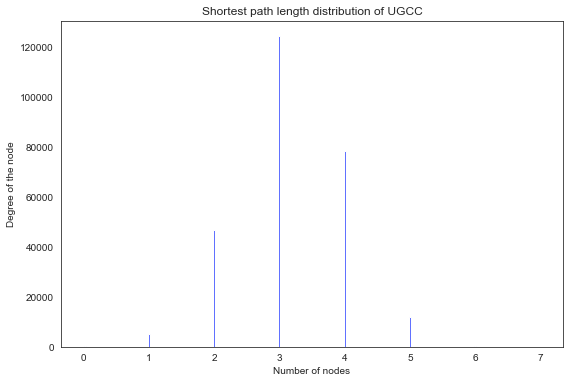

In [65]:
plt.hist(x=path_lengths_dg, bins='auto',color='#6171FF')
plt.title("Shortest path length distribution of UGCC")
plt.xlabel('Number of nodes')
plt.ylabel('Degree of the node')
plt.show()

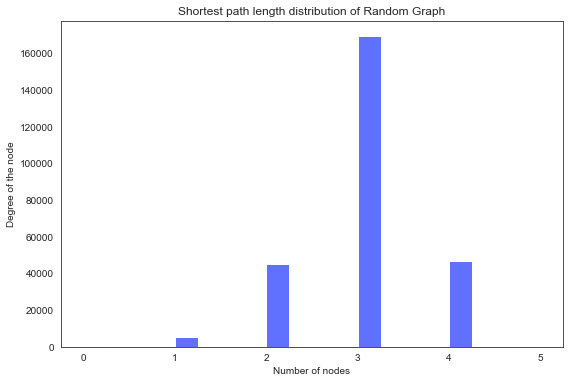

In [67]:
plt.hist(x=path_lengths_gr, bins='auto',color='#6171FF')
plt.title("Shortest path length distribution of Random Graph")
plt.xlabel('Number of nodes')
plt.ylabel('Degree of the node')
plt.show()

We can see that in our graph on average we need more nodes to get to another one than in a random network. In the aesthetics
network we have nodes that can be connected with a very long path of as much as 7 edges which is not possible in a 
corresponding random network.

### Communities

In this section we assign communities to our nodes by using Louvain Algorithm and assign them names based on the 3 most connected aesthetics.

In [70]:
# assign communities and check the number
partition = community_louvain.best_partition(UGCC)
unique_comms = list(set(partition.values()))
len(set(partition.values()))

9

In [71]:
# assign communities as an attribute in networks
nx.set_node_attributes(UGCC, partition, "partition")
nx.set_node_attributes(DGCC, partition, "partition")

In the next cells we process the community data to assign them a name based on 3 most connected aesthetics.

In [187]:
sums = {}
coms = []
for x in set(partition.values()):
    sums[x] = sum(value == x for value in partition.values())
    coms.append([k for k,v in partition.items() if v == x])

In [188]:
all_coms = [x[0] for x in sorted(sums.items(), key=lambda x: x[1], reverse=True)]
all_coms.sort()

In [189]:
#Sorting the aesthetics by edges and communities
ch_1=[]
for n in UGCC.nodes():
    ch_1.append((n,UGCC.degree(n),UGCC.nodes()[n]['partition']))

ch_1.sort(key=lambda x:x[1],reverse=True)
ch_1.sort(key=lambda x:x[2])

In [190]:
ch_big = [x for x in ch_1 if x[2] in all_coms]

In [191]:
#Name each community by its three most connected aesthetics.
count=0
com_name={}
for i in range(len(ch_big)):
    if count>=len(all_coms):
        break
    if ch_big[i][2]==all_coms[count]:
        com_name[all_coms[count]]=str(ch_big[i][0])+"-"+str(ch_big[i+1][0])+"-"+str(ch_big[i+2][0])
        count+=1
        continue

    

List of communities named after 3 most connected aesthetics.

In [85]:
com_name

{0: 'Dark Academia-Art Academia-Light Academia',
 1: 'Vaporwave-Cyberpunk-Lo-Fi',
 2: 'Cottagecore-Naturecore-Witchcore',
 3: 'Dreamy-After Hours-Traumacore',
 4: 'Vintage-Punk-Goth',
 5: 'Baddie-Boujee-Brocore',
 6: 'Neo-Romanism-Steampunk-Retro-Futurism',
 7: 'Pastel-Kidcore-Kawaii',
 8: 'Foodie-Ocean Grunge-Tropical'}

In [86]:
# we deal with nodes that might not have the community if we name only the biggest ones
comm_names = dict([(key, {'comm_name':com_name[partition[key]]}) if partition[key] in com_name.keys() else (key, {'comm_name':'Other'}) for key in partition ])

In [91]:
# value of modularity for the best partition
community_louvain.modularity(partition, UGCC)

0.4838718295810772

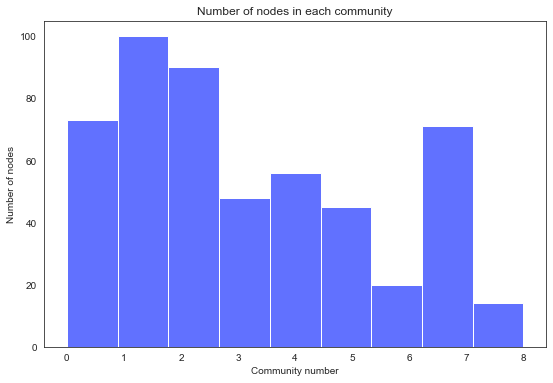

In [90]:
plt.hist(partition.values(), len(set(partition.values())),color='#6171FF')
plt.title("Number of nodes in each community")
plt.xlabel('Community number')
plt.ylabel('Number of nodes')
plt.show()

From the distribution of nodes amongst communities we can see that we have fairly balanced communities and a small number of them.
It means that based on the network properties we can distinguish clear groups of similar aesthetics. We will explore them in
the next part.

## Interactive graph visualisation

One of our biggest challenges was to explain people what a certain aesthetic's name actually refers to. We created 
an interactive visualisation of our network so that a person can not only see the general structure but also to get
detailed data on every single node. The summaries used as properties of the nodes are loaded from file but their
origin is explained in the text analysis part.

Setting attributes used in the visualisation

In [92]:
nx.set_node_attributes(UGCC, comm_names)
nx.set_node_attributes(UGCC, summaries)

In [95]:
d = dict(DGCC.degree)
for char in d.keys():
    d[char] = {'deg':d[char]}   
    
new_d = {str(key): str(partition[key]) for key in partition}

Create the graph using bokeh library.
- Possibilty to drag, scroll and zoom
- Hovering over a node brings details
- Colored by communities
- Clicking a node highlights it's neighbors

In [264]:
# Prepare Data
G = UGCC

SAME_PARTITION_COLOR, DIFFERENT_PARTITION_COLOR = "black", "red"
# sizes = [v*5 for v in list(d.values())]
partition_list = [v for v in list(partition.values())]

edge_attrs = {}

for start_node, end_node, _ in G.edges(data=True):
    edge_color = SAME_PARTITION_COLOR if G.nodes[start_node]["partition"] == G.nodes[end_node]["partition"] else DIFFERENT_PARTITION_COLOR
    edge_attrs[(start_node, end_node)] = edge_color

nx.set_edge_attributes(G, edge_attrs, "edge_color")
nx.set_node_attributes(G, d)
mapper = linear_cmap(field_name='partition', palette=Turbo256, low = min(partition_list), high = max(partition_list))

# Show with Bokeh
plot = Plot(width=800, height=800,
            x_range=Range1d(-0.6, 0.6), y_range=Range1d(-0.6, 0.6))

node_hover_tool = HoverTool(tooltips=[("Aesthetics", "@index"), ("Summary", "@summary"), ("Content length", "@loc"), ("Degree", "@deg"), ("Community name: ", "@comm_name"), ("Community num: ", "@partition")])
plot.add_tools(node_hover_tool, PanTool(), WheelZoomTool(), ResetTool(), TapTool())

graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0,0))

graph_renderer.node_renderer.glyph = Circle(size="deg", fill_color=mapper, fill_alpha = 0.7)
graph_renderer.node_renderer.selection_glyph = Circle(size="deg", fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size="deg", fill_color=Spectral4[1])

graph_renderer.edge_renderer.glyph = MultiLine(line_color="edge_color", line_alpha=0.1, line_width=1)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5)

graph_renderer.selection_policy = NodesAndLinkedEdges()


plot.toolbar.active_scroll = plot.select_one(WheelZoomTool)
plot.renderers.append(graph_renderer)

tab1 = Panel(child=column(plot), title="Aesthetics Wiki graph")
# show(plot)

In [273]:
show(plot)

This visualisation is the essential part of our project. It brings together multiple analyses and allows anyone to actually
see what a certain aesthetics is about and how is it related to other ones. We can see for example a light blue (might change if rerun)
community related to big node of Cottagecore or an interesting one (violet) related to Academia, Modernism and different forms
of art. Explore and have fun!

## Text analysis and WordClouds

## Text analysis

The aim here is to understand the definition of aesthetics better, and what is our data about.

First, we read the aesthetics list:

In [97]:
df_aesthetics = pd.read_csv('aesthetics.csv')

Now, we need a list of file names to create a corpus.

In [98]:
file_list=[]

for aest in list(df_aesthetics['0']):
    aest_file = aest.replace('/','_')
    file_list+=[aest_file+".txt"]

We take the **clean** folder in our current directory and the list of files created in the previous step, and create a corpus for the clean files.

In [101]:
corpus_root = os.getcwd()+'/clean'

wordlists = PlaintextCorpusReader(corpus_root, file_list)

wholeText = nltk.Text(wordlists.words())

We then print basic information about our corpus.

In [102]:
print("The total number of words in the corpus is {:d}, including {:d} different words. Lexical diverity is equal to {:2f}".format(len(wholeText), len(set(wholeText)), len(set(wholeText)) / len(wholeText)))

The total number of words in the corpus is 212748, including 26533 different words. Lexical diverity is equal to 0.124716


Let's take a look at the most frequent words in our corpus.

In [103]:
fdist1 = FreqDist(wholeText)
fdist1

FreqDist({'the': 10224, 'and': 7952, 'of': 6456, 'to': 4227, 'a': 4180, 'in': 3523, 'is': 3123, 'as': 2414, 'by': 2262, 'with': 2086, ...})

Now we plot the frequency distribution of the corpus.

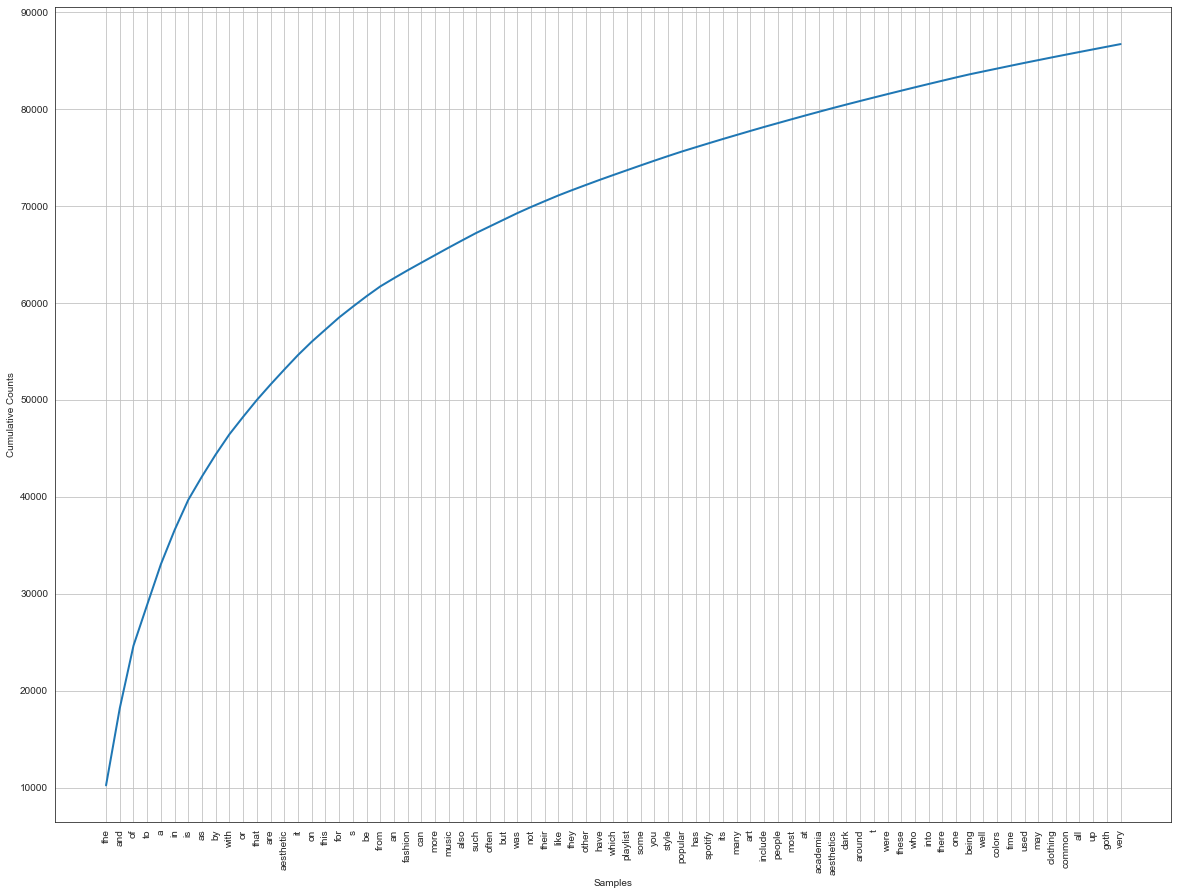

<AxesSubplot:xlabel='Samples', ylabel='Cumulative Counts'>

In [104]:
plt.figure(figsize=(20, 15))
fdist1.plot(75, cumulative=True)

Not so informative, because of the massive amount of stopwords, lest use the tokenized text!

In [105]:
corpus_root = os.getcwd()+'/cleaner'

wordlists_nostop = PlaintextCorpusReader(corpus_root, file_list)

nostopText = nltk.Text(wordlists_nostop.words())

Basic info about the new corpus:

In [106]:
print("The total number of words in the tokenized corpus is {:d}, including {:d} different words. Lexical diverity in this case is equal to {:2f}".format(len(nostopText), len(set(nostopText)), len(set(nostopText)) / len(nostopText)))

The total number of words in the tokenized corpus is 127637, including 26181 different words. Lexical diverity in this case is equal to 0.205121


Now, we try to understand the aesthetics by looking at dispersio plot of different words, that we've chosed arbitrarily.

In our case, in doesn't make sense to analyse at which places of the dispersion plot do the particular words occur. What does make sense, however is to look at the 'density' of occurrence of some words. 

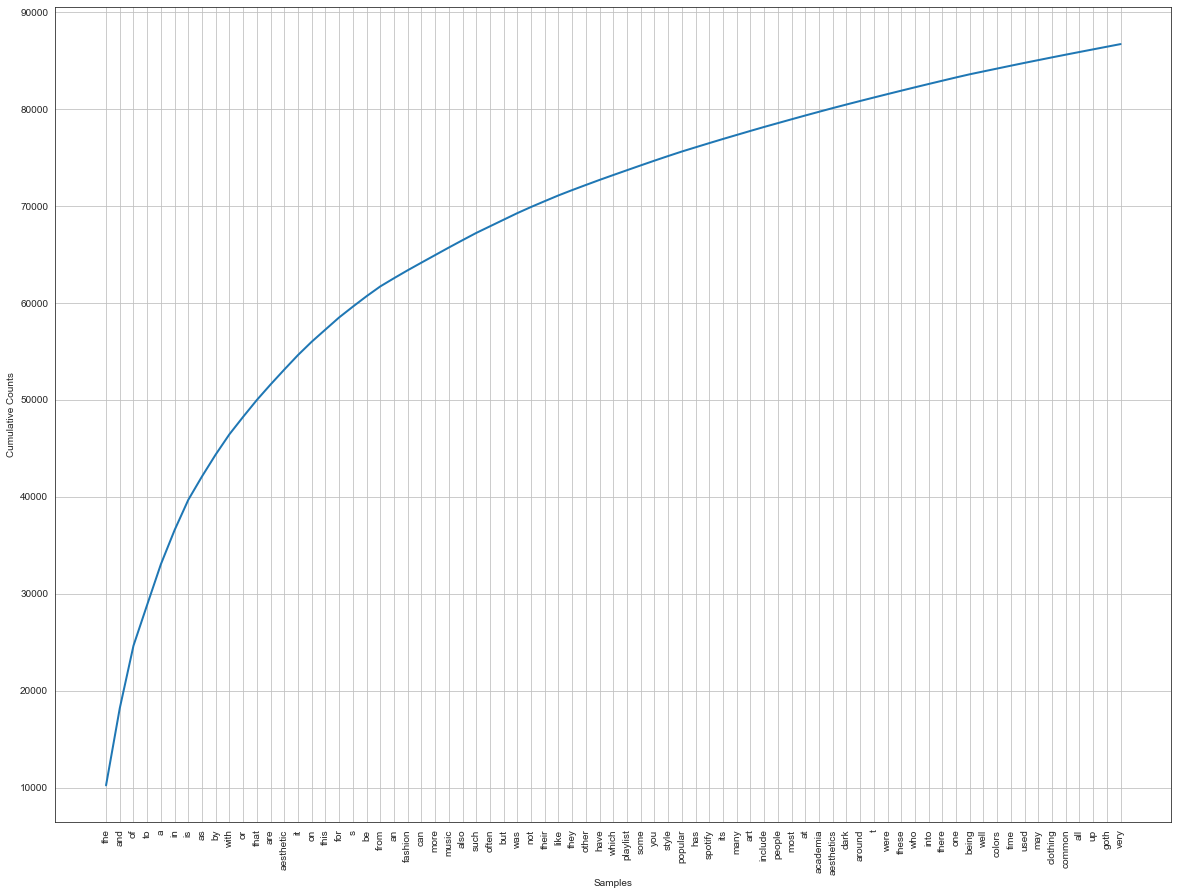

In [107]:
fdist1 = FreqDist(wholeText)
fdist1

plt.figure(figsize=(20, 15))
fdist1.plot(75, cumulative=True)
disp = ['aesthetic', 'fashion', 'music', 'style','art', 'people', 'colors']

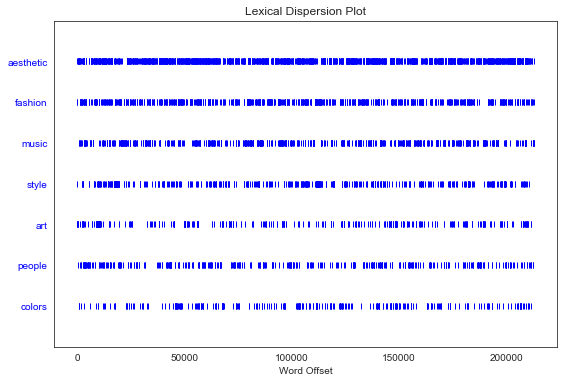

In [78]:
wholeText.dispersion_plot(disp)

Nice attempt, but not necessairly the great insight. Let's try different approach.
Now, we'll look at the possible cagtegories of aesthetics.

In [108]:
disp2 = ['architecture', 'music', 'fashion', 'art', 'culture', 'nature']

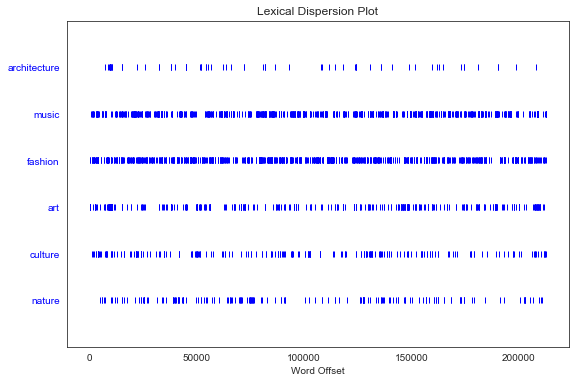

In [109]:
wholeText.dispersion_plot(disp2)

We wanted to examine what areas of beauty and art do the aesthetics refer to. It's clear that the vast majority are connected to fashion and music. Less of them, but still a lot, are concerned with art, culture and nature. And some of them reflect architecture.

In [110]:
wholeText.collocations()

spotify playlist; hip hop; better understanding; help get; video
games; centered around; jersey shore; united states; dark academia;
revolves around; external links; color palette; also known; hot topic;
femme fatale; new york; avant garde; vacation dadcore; social media;
https www


Collocations are not very informative, but give us a hint that possibly a lot of aesthetics have related spotify playlist, and that there might be some noise in the data.

## WordClouds

Now, we will take a look at wordclouds for the 5 biggest communities.
In order to do so, we have to calculate the Term frequency–Inverse document frequency (TF-IDF) for each of the word within each community.

First, we create a corpus for each of the 5 biggest community. Then we create a dict containing corpora for all of them. Having done that, the TF for words for each community is computed using simple loops, and according to the equation below:

$ tf(t,d) = \frac{f{t,d}}{\sum_{t'∈d} f{t',d}} $

*where ft,d is the raw count of a term in a document, i.e., the number of times that term t occurs in document d.* 

Then IDF values for each word in the whole corpus were computed and put in the dict. We treated each community corpus as documents over which idf was calculated. We used the following idf equation:

$ idf(t,D) = \frac{N}{n{t}} $

*where N is the total number of documents in the corpus and nt is the number of documents where the term *t* appears.* 


TFIDF was then computed simply by multiplying the above values for each of the communities. 

In order to prepare the scores for computing wordclouds they were multiplied by 10000 and rounded to integers.

Having the scores values ready the strings for Wordcloud function were prepared accoring to the score numbers. 

In order to make the wordcloud more intresting and unique for each community the masks were applied, which were the pictures representing the most connected aesthetic of the community.

As expected, each of the communities has different words that represent them.

*Note, that each time that the code is run, the partitioning may be different, and community numbers might differ, therefore, if the code is rerun, the resulting wordclouds' masks might lose their sense. If you want to run the code yourself you should take that into consideration ;)*

In [111]:
sums = {}
coms = []
for x in set(partition.values()):
    sums[x] = sum(value == x for value in partition.values())
    coms.append([k for k,v in partition.items() if v == x])

Then, we define the 5 biggest communities.

In [112]:
big_coms = [x[0] for x in sorted(sums.items(), key=lambda x: x[1], reverse=True)][:5]

Let's take a look at which communities are the biggest:

In [113]:
big_coms.sort()
big_coms

[0, 1, 2, 4, 7]

The goal of the next three cells is to name large communities after the three most connected aesthetics

In [114]:
#Sorting the aesthetics by edges and communities
ch_1=[]
for n in UGCC.nodes():
    ch_1.append((n,UGCC.degree(n),UGCC.nodes()[n]['partition']))

ch_1.sort(key=lambda x:x[1],reverse=True)
ch_1.sort(key=lambda x:x[2])

In [115]:
ch_big = [x for x in ch_1 if x[2] in big_coms]

In [116]:
#Name each community by its three most connected characters.
count=0
com_name={}
for i in range(len(ch_big)):
    if count>=len(big_coms):
        break
    if ch_big[i][2]==big_coms[count]:
        com_name[big_coms[count]]=str(ch_big[i][0])+"-"+str(ch_big[i+1][0])+"-"+str(ch_big[i+2][0])
        count+=1
        continue

    

Let's look at the new names of our 5 biggest communities:

In [117]:
com_name

{0: 'Dark Academia-Art Academia-Light Academia',
 1: 'Vaporwave-Cyberpunk-Lo-Fi',
 2: 'Cottagecore-Naturecore-Witchcore',
 4: 'Vintage-Punk-Goth',
 7: 'Pastel-Kidcore-Kawaii'}

Here is the moment of defining our masks. If you want to recreate this step of analysis take a look at the note in the description of this step of analysis.

In [125]:
imag = ['academia', 'vapor', 'cottage','goth','pastel']

Now, we create a dictionary with communities' corpora

In [119]:
community_corpora={}
# community corpora dict
for com in [x[0] for x in sorted(sums.items(), key=lambda x: x[1], reverse=True)]:
    char = coms[com]
    
    char = [x.replace('/','_') for x in char]
    
    clist = [i+".txt" for i in char]
    
    wordlists_ = PlaintextCorpusReader(corpus_root, clist)
    community_corpora[com]= nltk.Text(wordlists_.words())

Time to count TF for each word in each community (according to the equation in the description at the top of the subsection)

In [121]:
comunity_tf={}
# TF count
for x in big_coms:
    l=[]
    l = sorted(dict(FreqDist(community_corpora[x])).items(), key=lambda x: x[1], reverse=True)
    d={}
    for y in l:
        d[y[0]] = y[1]/len(community_corpora[x])
    comunity_tf[x] = d

Let's just take a look if we obtained sensible values

In [122]:
for r in comunity_tf:
    print(sorted(comunity_tf[r].items(), key = lambda x: x[1], reverse = True)[:5])

[('academia', 0.018990246701090074), ('aesthetic', 0.010671256454388985), ('art', 0.009810671256454389), ('dark', 0.006769936890418818), ('music', 0.005220883534136547)]
[('aesthetic', 0.012222758851283575), ('music', 0.009807928075194115), ('fashion', 0.005795593862614704), ('vaporwave', 0.005609837649069361), ('playlist', 0.005498383920942156)]
[('aesthetic', 0.015176095033753728), ('fashion', 0.005756449840389345), ('often', 0.005337798942906484), ('like', 0.0047621539588675495), ('cottagecore', 0.0047621539588675495)]
[('goth', 0.014461060948081264), ('music', 0.009664221218961625), ('fashion', 0.00895880361173815), ('punk', 0.008112302483069978), ('aesthetic', 0.008112302483069978)]
[('aesthetic', 0.014430192402565368), ('fashion', 0.010051800690675875), ('lolita', 0.008386778490379871), ('playlist', 0.006906758756783424), ('often', 0.006413418845584608)]


Yeah, it seems so!

So, now we count TF-IDF for each word for each community:

In [124]:
N_com = len(community_corpora)

comunity_tfidf = comunity_tf.copy()
idf_com = {}

for word in set(nostopText):
    nt = 0
    for comu in community_corpora:
        if word in set(community_corpora[comu]):
            nt+=1
    idf_com[word] = math.log((N_com/(nt+1)),10)
    
for comu in comunity_tfidf:
    for word in comunity_tfidf[comu]:
        comunity_tfidf[comu][word] = int(comunity_tfidf[comu][word]*idf_com[word]*10000) # multiplying by 10000 and changing into integer to prepare the scores for wordclouds

Again, let's just take a look if we obtained sensible values

In [126]:
for r in comunity_tfidf:
    print(sorted(comunity_tfidf[r].items(), key = lambda x: x[1], reverse = True)[:5])

[('academia', 9), ('academics', 8), ('impressionism', 7), ('ballet', 6), ('greek', 5)]
[('seapunk', 7), ('breakcore', 7), ('trillwave', 6), ('cyberpunk', 5), ('raver', 5)]
[('goblincore', 10), ('caninecore', 6), ('cryptidcore', 6), ('goblins', 6), ('cottagecore', 5)]
[('goths', 8), ('goth', 7), ('shamate', 7), ('vampire', 6), ('metalcore', 6)]
[('kawaii', 18), ('lolita', 9), ('unicorn', 9), ('palewave', 6), ('normcore', 5)]


Yes sir!

What's left to do here is to create lists of words for each community, which we then pass for wordclouds. We do that as a dictionary - Community : list of words

In [128]:
wc_str = {}
# Do not include certain words from the tfidf
for comu in big_coms:
    wc_str[comu] = ''

    for x in comunity_tfidf[comu]:
        if x not in ('spotify','playlist','aesthetics', 'aesthetic'):
            wc_str[comu] += (x+' ')*comunity_tfidf[comu][x]

In [130]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

Finally, we compute wordclouds. We do it in the loop, so we compute all 5 of them at once. And additionally, for each of them we show the picture that we used as a mask for shape and colours of our wordclouds.

<Figure size 648x432 with 0 Axes>

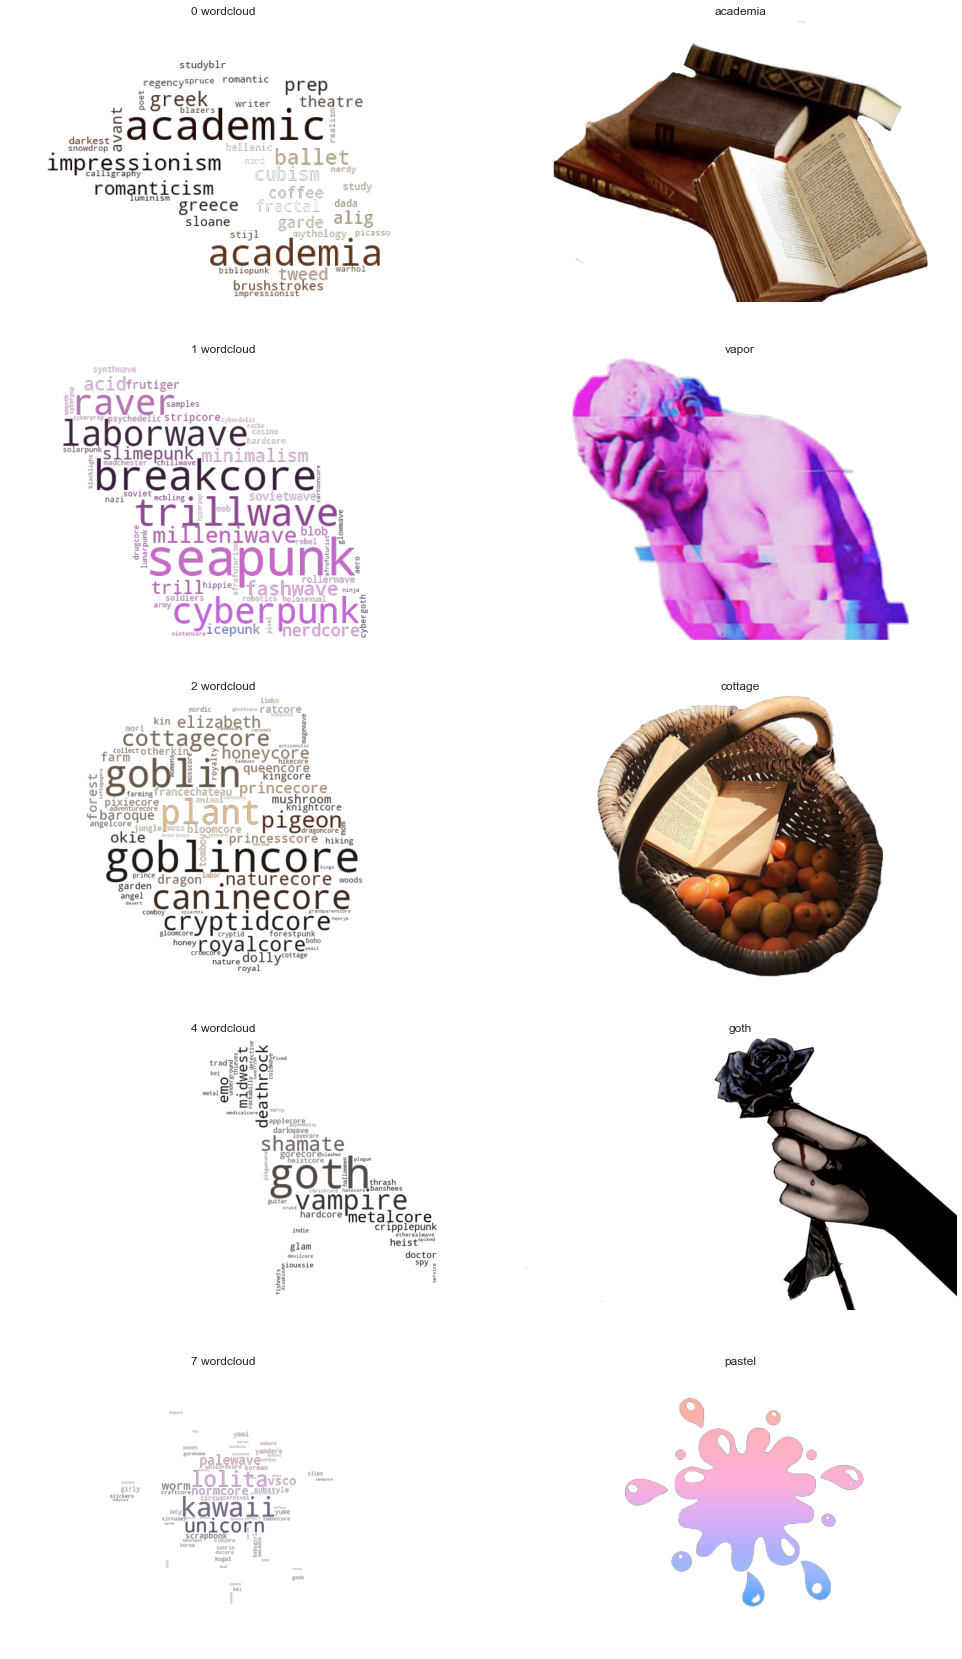

In [131]:
plt.figure()
stopwords = set(STOPWORDS)
plt.figure(figsize=[17, 30])

for t in range(len(big_coms)):
    plt.subplot(5, 2, 2*t+1).set_title(str(big_coms[t])+" wordcloud")
    
    mask = np.array(Image.open(imag[t]+".png"))
    transformed_mask = np.ndarray((mask.shape[0],mask.shape[1],mask.shape[2]), np.int32)
    for i in range(len(mask)):
        for j in range(len(mask[i])):
            transformed_mask[i][j] = list(map(transform_format, mask[i][j]))
            
    image_colors = ImageColorGenerator(mask)
    
    wordcloud = WordCloud(max_font_size=130, collocations = False, width = 600, height = 600,
                mode = 'RGBA',
                background_color =None,
                stopwords = stopwords,
                mask = transformed_mask,
                min_font_size = 10).generate(wc_str[big_coms[t]])
    
    wordcloud.recolor(color_func=image_colors).to_file(imag[t]+'_cloud.png')
    
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.subplot(5, 2, 2*t+2).set_title(imag[t])
    plt.imshow(mask, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
plt.show()

Let's try to make sense of the wordclouds!!!

**Cottagecore-Vintage-Naturecore**

The wordcloud clearly shows, that this community is related to nature (nature, forest, plant, animal etc.), royalty (queen, king, royalcore) and supernatural/fantasy world (angel, goblin)
Makes sense, isn't it? People have always looked for beauty within nature, which is also often connected with supernatural powers

**Pastel-Kawaii-Softie**

Aesthetics is complex enough that there can be apparent contradictions (cute and macabre; pink and goth; sweet and abuse). It seems to be only natural that seemingly opposite things can blend together when it comes to our understanding of beauty

**Punk-Goth-Grunge**

Let's get back to the question from our video: How close is goth to punk? Very close indeed! Both clothing and music seem important for this community, and surprisingly or not they are connected do mainstream somehow

**Dark Academia-Art Academia-Light Academia**

Academia is a group of aesthetics focused on learning, studying and researching. Words like "romanticism", "greek" ,"theater" clearly show the main inspirations of this community and allow us to understand them better.

**Vaporwave-Milleniwave-Kidcore**

This one is clearly a 'younger' trend within aesthetics. Words such as "video", "internet" or "car" prove that.  It is also not surprising that it is strongly associated with visuality. Interesting. No?

Comment on the result:

The above wordclouds, generated for different communities, show us the abundance of means of expressions, as well as the fact that aesthetics develop at different times and are somewhat fluid, and interconnected

## Advanced Text Analysis

In this section we are interested in analyzing different aspects of the text of each wiki page.

We are interested in generating a short and easy to read summary of the description of each aesthetic to display it in the visuals of the web page.

We are also interested in analyzing the the sentiment analysis of each aesthetic to determine the happiest and saddest. Additionally, we will perform these analysis into the communities generated in the previous sections.

Finally, we analyze the description symilarities to create a new network based on this and compare it with the original one.

### Description Summary

This section is dedicated to create a summary of the description of each aesthetics. 

We use a method uses a simple approach of splitting each file into sentences to measure the cosine distance between them. Once we have this, we generate a similarity matrix to convert each sentence into np vector. Later, we create a graph to use the page_rank algorithm to calculate the importance of each sentence and get the 2 most important sentences which are the ones that integrate the summary.

We followed the code and instructions in "Understand Text Summarization and create your own summarizer in python. An Introduction to Text Summarization" (Dubey, P., 2018).
It can be reviewed in https://towardsdatascience.com/understand-text-summarization-and-create-your-own-summarizer-in-python-b26a9f09fc70

First, we create a function that loads the description of each aesthetic. We have the descriptions saved in .txt files 

In [132]:
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx
 
def read_article(file_name):
    with open('text_analysis/'+f'{file_name}.txt', 'r',encoding="utf-8") as f:
        clean=f.read()
    article = clean.split(". ")
    sentences1 = []

    for sentence in article:
        sentences1.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
    sentences1.pop() 
    
    for i in sentences1:
        if i == ['']:
            sentences1.remove(i)
            
    sentences=sentences1.copy()
    
    return sentences

We generate a function that calculate the cosine distance of the sentences.

In [133]:
def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
    
    return 1 - cosine_distance(vector1, vector2)

We create a function that takes the the vectors of the cosine distance and create a similarity matrix to assess the similarity between the sentences. 

In [134]:
def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix

We generate a function that calls the previous ones and get the top 2 highest ranked sentences to join them and generate the summary of the text.

In [135]:
def generate_summary(file_name, top_n=2):
    stop_words = stopwords.words('english')
    summarize_text = []

    # Step 1 - Read text anc split it
    sentences =  read_article(file_name)

    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)
    
    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph,max_iter=500000)
    
    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)     
    
    if len(ranked_sentence) < top_n:
        top_n=len(ranked_sentence)
    
    for i in range(top_n):
        summarize_text.append(" ".join(ranked_sentence[i][1]))
    
    return summarize_text

We run the summarization functions into all the description files we have stored to generate the abstracts and save the results into new .txt files for further use.

In [136]:
for file in DG:
    char_file = file.replace('/','_')
    char_file = char_file.replace('/','_')
    if file =="Horror":
        continue
    else:   
        txt_sum=generate_summary(char_file,2)
        txt_sum_final=""
        delimiter=". "
        txt_sum_final=delimiter.join(txt_sum)

        with open('text_sum/'+f'{char_file}.txt', 'w',encoding="utf-8") as f:
            f.write(txt_sum_final)

The summarization method works for all description except for the "Horror" one. For this file, the cosine distance does not converge within the max iterations we set and generates an error.
To work around it, we adapt the method and run it again only with the file to successfully generate the abstract for the Horror aesthetic.

In [137]:
stop_words = stopwords.words('english')
char_file='Horror'
top_n=2
summarize_text = []
with open('text_analysis/'+f'{char_file}.txt', 'r',encoding="utf-8") as f:
    clean=f.read()
    article = clean.split(".")
    sentences = []

    for sentence in article:
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
    
        
    for i in sentences:
        if i == ['']:
            sentences.remove(i)
            
sum_sentences=[]
sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)
sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
scores = nx.pagerank(sentence_similarity_graph,max_iter=600)
ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
sum_sentences.append(ranked_sentence[0][1])
sum_sentences.append(ranked_sentence[1][1])

summarize_text.append(" ".join(sum_sentences[0]))
summarize_text.append(" ".join(sum_sentences[1]))
        
txt_sum_final=""
delimiter=". "
txt_sum_final=delimiter.join(summarize_text)

with open('text_sum/'+f'{char_file}.txt', 'w',encoding="utf-8") as f:
    f.write(txt_sum_final)

The method works well for the mayority of the aesthetics, however, it has some issues with the aesthetics that has names with abreviations like J. P. or others that use a dot. This is because the sentence tokenizer uses the dot as a split token and the method interprets each letter as a separate sentece and not a name.

### Sentiment Analysis for each Aesthetic using LabMT and VADER

In this section we will analyze the sentiment analysis using the VADER and LabMT methods to find the happiness and saddness of each aesthetic and community.


We load the labMT word list for later use.

In [138]:
#loading labMT as a df
df_lab = pd.read_csv('labMT.csv',sep=';')
df_lab

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1.0,8.50,0.9313,3600,--,--,1728
1,happiness,2.0,8.44,0.9723,1853,2458,--,1230
2,love,3.0,8.42,1.1082,25,317,328,23
3,happy,4.0,8.30,0.9949,65,1372,1313,375
4,laughed,5.0,8.26,1.1572,3334,3542,--,2332
...,...,...,...,...,...,...,...,...
10217,murder,10218.0,1.48,1.0150,2762,3110,1541,1059
10218,terrorism,10219.0,1.48,0.9089,--,--,3192,--
10219,rape,10220.0,1.44,0.7866,3133,--,4115,2977
10220,suicide,10221.0,1.30,0.8391,2124,4707,3319,2107


With the libraries and the word list loaded we proceed to calculate the VADER and LabMT score of each aesthetic and store it into a list for each method.

In [139]:
stop_words = list(set(stopwords.words('english')))
char_hap = []
char_vad=[]
lemmatizer = WordNetLemmatizer()

#loads the content of each aesthetic and splits it by sentences
for file in DG:
    char_file=file.replace('/','_')
    char_file=char_file.replace(' ','_')
    text_words = []
    with open('sentiment/'+f'{char_file}.txt', 'r',encoding="utf-8") as f:
        clean=f.read()
        sent_text = nltk.sent_tokenize(clean)
        tokenized_text = nltk.word_tokenize(clean)

        for i in tokenized_text:
            if i in stop_words or not i.isalpha():
                tokenized_text.remove(i)
            else:
                text_words.append(lemmatizer.lemmatize(i.lower()))

#Calculating the LabMT score for each aesthetic 
    sent_avg = 0 
    count = 0
    for i in text_words:
        try:            
            if i in df_lab.word.to_list():
                sent_avg+=float(df_lab.loc[df_lab['word']==i]['happiness_average'].to_string(index=False))
                count+=1
        except:
            continue
    if count != 0:
        sent_avg/=count
        char_hap.append((char_file,sent_avg))
    else:
        char_hap.append((char_file,0))

#Calculating the Vader score for each aesthetic 
    analyzer = SentimentIntensityAnalyzer()
    sent_comp = 0 
    count = 0
    for i in sent_text:
        try:
            vs = analyzer.polarity_scores(i)
            sent_comp+=vs['compound']
            count+=1
        except:
            continue
    if count != 0:
        sent_comp/=count
        char_vad.append((char_file,sent_comp))
    else:
        char_vad.append((char_file,0))

Once we have the scores we can sort the lists from highest to lowest or reverse them to get the top and bottom for each method.

In [163]:
char_vad2=sorted(char_vad, key=itemgetter(1),reverse=True)
happiest_char=char_vad2[0:10]

print("The 10 happiest aesthetics according to the VADER method are \n")
pd.DataFrame(happiest_char)

The 10 happiest aesthetics according to the VADER method are 



,0,1
0,Bunnycore,0.906000
1,Miami_Metro,0.768000
2,Lagenlook,0.719167
3,Snowdrop,0.693875
4,Romantic_Goth,0.690100
5,Scrapbook,0.682871
6,Ethereal,0.666225
7,Nanopunk,0.664950
8,Summer,0.664220
9,Happycore,0.652917


In [164]:
char_vad2=sorted(char_vad, key=itemgetter(1))
happiest_char=char_vad2[0:10]

print("The 10 saddest aesthetics according to the VADER method are \n")
pd.DataFrame(happiest_char)

The 10 saddest aesthetics according to the VADER method are 



,0,1
0,Nuclear,-0.536533
1,Cottagegore,-0.531075
2,Bastardcore,-0.515740
3,Horror,-0.484903
4,Yakuza,-0.435400
5,Hatecore,-0.419850
6,Yanki,-0.393871
7,Southern_Gothic,-0.393850
8,Anglo_Gothic,-0.392771
9,Postmodernism,-0.390200


In [165]:
char_hap2=sorted(char_hap, key=itemgetter(1),reverse=True)
happiest_char=char_hap2[0:10]

print("The 10 happiest aesthetics according to the LabMT method are \n")
pd.DataFrame(happiest_char)

The 10 happiest aesthetics according to the LabMT method are 



,0,1
0,Bookstore_Girl,6.612000
1,Glam_Girl,6.411333
2,Ukiyo-e,6.369600
3,Plant_Mom,6.296349
4,Lagenlook,6.279545
5,Spring,6.257209
6,Pixel_Cutie,6.249600
7,Magenta,6.244167
8,Romantic_Italian,6.213731
9,Fairy_Academia,6.189600


In [166]:
char_hap2=sorted(char_hap, key=itemgetter(1))
happiest_char=char_hap2[0:10]

print("The 10 saddest aesthetics according to the LabMT method are \n")
pd.DataFrame(happiest_char)

The 10 saddest aesthetics according to the LabMT method are 



,0,1
0,Nuclear,5.050769
1,Bogan,5.084000
2,Stonepunk,5.118824
3,Cholo,5.181193
4,Pointillism,5.235000
5,Gorecore,5.246489
6,Hatecore,5.248824
7,Scuttlers,5.336000
8,Military,5.339640
9,Dark_Nymphet,5.342000


Just by looking at the names we can see how well we can estimate a sentiment of an aesthetic. Things like 
Hatecore  and Horror come out sad, while Pixel Cutie and Romantic Italian are considered by the algorithm
as happy ones.

We proceed to plot the distribuition of the occurences of scores to visualize the results.

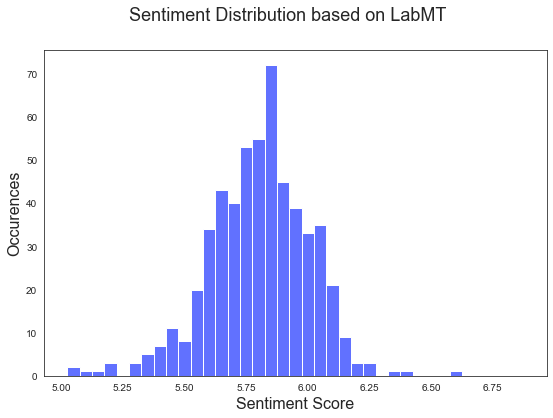

In [167]:
minimum=char_hap2[0][1]
maximum=char_hap2[-1][1]

char_labmt=[]

for i in range(len(char_hap)):
    char_labmt.append(char_hap[i][1])

b = np.array(np.arange(minimum,maximum+0.3,0.05))
hist,bins = np.histogram(char_labmt,b)
 
fig = plt.figure()
bar = plt.bar(b[:-1],hist,width=0.05,color='#6171FF')
fig.suptitle('Sentiment Distribution based on LabMT', fontsize=18)
plt.xlabel('Sentiment Score', fontsize=16)
plt.ylabel('Occurences', fontsize=16)
plt.show()

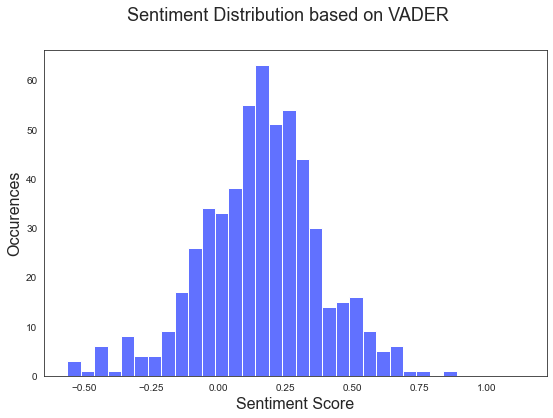

In [168]:
minimum=char_vad2[0][1]
maximum=char_vad2[-1][1]

char_vad3=[]

for i in range(len(char_vad)):
    char_vad3.append(char_vad[i][1])

b = np.array(np.arange(minimum,maximum+0.3,0.05))
hist,bins = np.histogram(char_vad3,b)
 
fig = plt.figure()
bar = plt.bar(b[:-1],hist,width=0.05,color='#6171FF')
fig.suptitle('Sentiment Distribution based on VADER', fontsize=18)
plt.xlabel('Sentiment Score', fontsize=16)
plt.ylabel('Occurences', fontsize=16)
plt.show()

This section allows us to identify the happiest and saddest aesthetics in the wiki. As expected, aesthetics related to fairy, bunnies, seasons, and colors stand out in both methods, however, for the VADRE method, the Romantic Goth appears as one of the happiest ones. Additionally, for the LabMT method stand out that 3 of the top 5 aesthetics are related to Girl and Mom.  

### Sentiment Analysis in communities using LabMT and VADER

In this section we calculate the average sentiment in the communities using the VADER and LabMT methods. 

First we start by reorganizing the two lists containing the scores VADER and LabMT scores, and the list with the aesthetics and communities in alfabethical order. This way we can join the name of the aesthetic, its community and scores into one list.

In [146]:
char_vad.sort(key = lambda x: x[0])
char_hap.sort(key = lambda x: x[0])
ch_1.sort(key = lambda x: x[0])

In [147]:
com_list=[]

dct_vad = dict((x, y) for x, y in char_vad)
dct_hap = dict((x, y) for x, y in char_hap)

for c in ch_1:
    char = c[0].replace(' ','_')
    char = char.replace('/','_')
    com_list.append((char,dct_hap[char],dct_vad[char],c[2]))

We order the list according to the communities.

In [148]:
com_list.sort(key = lambda x: x[3])

We calculate the average and standard deviation of each community and the count of individuals in them.

In [192]:
com_stats=[]

com_max=max(com_list,key=itemgetter(3))[3]

for i in range(com_max+1):
    count=0
    vad_community = []
    hap_community = []
#     com_name=""
    
    for j in com_list:
        if j[3]==i:
            hap_community.append(j[1])
            vad_community.append(j[2])
#             if count<=3:
#                 com_name+=str(j[0])+"-"
#             count+=1
    com_name_cur = com_name[i]        
#     com_name = com_name[:-1]
    if len(hap_community)<=1: # Statistic modelue uses the sample standard deviation formula and in communities with 1 element if fails because it devides by 0 (N-1)
                com_stats.append((com_name_cur,statistics.mean(vad_community),0,
                              statistics.mean(hap_community),0,count))
    else:
        com_stats.append((com_name_cur,statistics.mean(vad_community),statistics.stdev(vad_community),
                          statistics.mean(hap_community),statistics.stdev(hap_community),count))      

We can find the top 3 of highest and saddest communities by sorting the list from highest to lowest or reverse them to get the top and bottom for each method. 

In [193]:
VAD_sort_top=sorted(com_stats, key=itemgetter(1),reverse=True)
top3_VAD=VAD_sort_top[0:3]

print("The 3 happiest communities according to VADER are \n")
for w in range(3):
      print(top3_VAD[w][0],top3_VAD[w][1])

The 3 happiest communities according to VADER are 

Pastel-Kidcore-Kawaii 0.2900911642244096
Foodie-Ocean Grunge-Tropical 0.27291825428248223
Cottagecore-Naturecore-Witchcore 0.24075073691403956


In [194]:
VAD_sort_bot=sorted(com_stats, key=itemgetter(1))
bot3_VAD=VAD_sort_bot[0:3]

print("The 3 saddest communities according to VADER are \n")
for w in range(3):
      print(bot3_VAD[w][0],bot3_VAD[w][1])

The 3 saddest communities according to VADER are 

Neo-Romanism-Steampunk-Retro-Futurism 0.08669217795260295
Dreamy-After Hours-Traumacore 0.09714962641324866
Vintage-Punk-Goth 0.09931035171050255


In [195]:
labMT_sort_top=sorted(com_stats, key=itemgetter(3),reverse=True)
top3_labMT=labMT_sort_top[0:3]

print("The 3 happiest communities according to labMT are \n")

for w in range(3):
      print(top3_labMT[w][0],top3_labMT[w][3])

The 3 happiest communities according to labMT are 

Foodie-Ocean Grunge-Tropical 5.9705841202687076
Pastel-Kidcore-Kawaii 5.907760680050186
Cottagecore-Naturecore-Witchcore 5.8727937735800175


In [196]:
labMT_sort_bot=sorted(com_stats, key=itemgetter(3))
bot3_labMT=labMT_sort_bot[0:3]
print("The 3 saddest communities according to labMT are \n")
for w in range(3):
      print(bot3_labMT[w][0],bot3_labMT[w][3])

The 3 saddest communities according to labMT are 

Vintage-Punk-Goth 5.719998284472943
Baddie-Boujee-Brocore 5.742924946449451
Neo-Romanism-Steampunk-Retro-Futurism 5.744520771303413


For easy plotting and better organizing the data we summarize the data in a DataFrame.

In [197]:
df = pd.DataFrame(com_stats, columns =['Name', 'VADER','VADER_sd', 'LabMT','LabMT_sd','Total aesthetics'])
df

,Name,VADER,VADER_sd,LabMT,LabMT_sd,Total aesthetics
0,Dark Academia-Art Academia-Light Academia,0.196519,0.218381,5.869642,0.211162,0
1,Vaporwave-Cyberpunk-Lo-Fi,0.179931,0.208758,5.808865,0.187735,0
2,Cottagecore-Naturecore-Witchcore,0.240751,0.188152,5.872794,0.179542,0
3,Dreamy-After Hours-Traumacore,0.097150,0.260254,5.787012,0.197195,0
4,Vintage-Punk-Goth,0.099310,0.234543,5.719998,0.197767,0
5,Baddie-Boujee-Brocore,0.141443,0.217511,5.742925,0.247217,0
6,Neo-Romanism-Steampunk-Retro-Futurism,0.086692,0.210224,5.744521,0.237315,0
7,Pastel-Kidcore-Kawaii,0.290091,0.197258,5.907761,0.151460,0
8,Foodie-Ocean Grunge-Tropical,0.272918,0.211151,5.970584,0.147873,0


We plot the average scores of the communities as a barplot with the standard deviation as the error bars.

<Figure size 648x432 with 0 Axes>

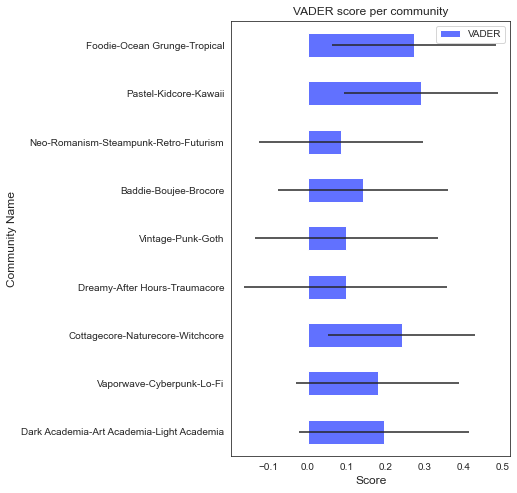

In [198]:
fig = plt.figure()
bar = df.plot(kind = "barh", y = "VADER", legend = True,
          x="Name",xerr="VADER_sd",
              title="VADER score per community", 
              color='#6171FF',figsize=(5,8))
plt.xlabel('Score', fontsize=12)
plt.ylabel('Community Name', fontsize=12)
plt.show()

<Figure size 648x432 with 0 Axes>

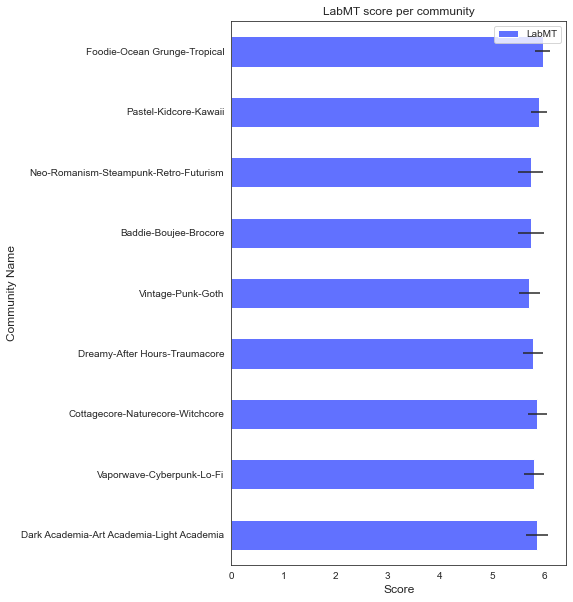

In [199]:
fig = plt.figure()
bar = df.plot(kind = "barh", y = "LabMT", legend = True,
          x="Name",xerr="LabMT_sd",title = "LabMT score per community", 
              color='#6171FF',figsize=(6,10))
plt.xlabel('Score', fontsize=12)
plt.ylabel('Community Name', fontsize=12)
plt.show()


The outcome of this section provides insights on the communities. We were able to successfully calculate the average sentiment of the communities and visualize how they behave as a group. Not surprisingly both LabMT and Vader indentifed Vintage-Punk-Goth community as one of the saddest and Pastel-Kidcore-Kawaii as the community of happy aesthetics. It aligns well with our conclusions so far.

### Text Similarities Based Network

In this section we assess the similarity between the description of each aesthetics. Our goal is to calculate the percentage of similarity between the texts and create a new network and link the aesthetics based on their text similarity.

We adapted the code and instructions in "An easy way to determine similarity between two strings of text using Python" (Tracyrenee, 2021). It can be reviewed in https://medium.com/geekculture/an-easy-way-to-determine-similarity-between-two-strings-of-text-using-python-de9b1b52f022

In [200]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize

similarities_total={}
sim_total=[]
used_aest=[]
super_sim=[]

#We load the content of each wiki page 
for file in DG:
    char_file=file.replace('/','_')
    char_file=char_file.replace(' ','_')
    similarities={}
    sim_list=[]
    with open ('sentiment/'+f'{char_file}.txt', 'r',encoding="utf-8") as f:
        my_text = f.read()
        
#We compare the content of one aesthetic with the content of all the aesthetics in the wiki.
    for file1 in DG:
        if file1 == file or file1 in used_aest:
            continue
        else:
            char_file1=file1.replace('/','_')
            char_file1=char_file1.replace(' ','_')
            text_words = []
            with open('sentiment/'+f'{char_file1}.txt', 'r',encoding="utf-8") as f:
                sk_text = f.read()

#Creating a corpus
            corpus = [my_text, sk_text]


#Converting the corpus to a matrix of TF-IDF features.
            from sklearn.feature_extraction.text import TfidfVectorizer

            vectorizer = TfidfVectorizer()
            trsfm=vectorizer.fit_transform(corpus)
            pd.DataFrame(trsfm.toarray(),columns=vectorizer.get_feature_names(),index=['my_doc','sk_doc'])

#Calculate the cosine similarity of the vectors in the matrix
            from sklearn.metrics.pairwise import cosine_similarity
            percentage_of_similarity=round(cosine_similarity(trsfm[0:1], trsfm)[0][1]*100)
        
#Storing the results for later use
            sim_list.append((file1,percentage_of_similarity))
            super_sim.append((file,file1,percentage_of_similarity))
            similarities[file1]=percentage_of_similarity
    sim_list.sort(key=lambda x:x[1], reverse=True)
    used_aest.append(file)
    similarities_total[file]=similarities
    sim_total.append((file,sim_list))

We sort the list with all the similarities highest to lowest, and take the top 3301 elements. We use this number of elements to link the nodes of the new graph, the original network has 3301 edges. 

In [201]:
sorted_by_second = sorted(super_sim, key=lambda tup: tup[2], reverse=True)
new_edges=sorted_by_second[:3301]

### Graph creation

We create a new graph woth all the aesthetics ans use the top 3301 percentages of similarities to create the edges. We create an undirected graph as the similiraty does not depend on the direction of a relation between two nodes. The purpose of the task was to compare somehow if the "Related Aesthetics" field on the Wiki corresponds somehow to the mathematical similarity of their descriptions.

In [202]:
g_new = nx.Graph()
g_new.add_nodes_from(similarities_total.keys())

We add edges to match the number of edges of the original graph

In [203]:
for i in new_edges:
    g_new.add_edge(i[0], i[1], weight=i[2])

Extract the GCC

In [204]:
# extraction of GCC and creation of the undirected version of the graph
largest_cc = max(nx.weakly_connected_components(g_new), key=len)
UGCC_new = g_new.subgraph(largest_cc)
d_new = dict(UGCC_new.degree)

#### Number of nodes

In [205]:
print(f'Number of nodes: {len(UGCC_new.nodes)}')
print(f'Number of nodes in the giant connected component: {len(UGCC_new.nodes)}')
print(f'Number of nodes not connected to the GCC: {len(g_new.nodes-UGCC_new.nodes)}')

Number of nodes: 266
Number of nodes in the giant connected component: 266
Number of nodes not connected to the GCC: 283


We remove all nodes without edges. We can already see that this graph is way different than our original one.

#### Number of edges

In [206]:
print(f'Number of edges: {len(UGCC_new.edges)}')
print(f'Number of edges in the giant connected component: {len(UGCC_new.edges)}')

Number of edges: 3300
Number of edges in the giant connected component: 3300


Number of edges comes from the assumptions.

In [207]:
# Top 5 most connected aesthetics undirected representation
sorted([
    {'name':x, 'value':UGCC_new.degree(x)} 
    for x,y in UGCC_new.nodes(data=True) 
], key=lambda k: k['value'],reverse=True)[0:10]

[{'name': 'Dark Academia', 'value': 233},
 {'name': 'Cottagecore', 'value': 219},
 {'name': 'Americana', 'value': 173},
 {'name': 'Vaporwave', 'value': 161},
 {'name': 'Milleniwave', 'value': 150},
 {'name': 'Preppy', 'value': 149},
 {'name': 'Nymphet', 'value': 147},
 {'name': 'Waif', 'value': 135},
 {'name': 'Bodikon', 'value': 118},
 {'name': '1950s Suburbia', 'value': 112}]

We see that top 5 nodes in terms of connections are the same ones as for the original graph. However, the next 5 are ones that were not really occuring in previous analyses.

We want to make once again an interactive visualisation to browse the graph

We assign the communities from the original graph to see if the nodes will stay close in this graph as well.

In [208]:
nx.set_node_attributes(UGCC_new, partition, "partition")

In [209]:
d_new = dict(UGCC_new.degree)
for char in d_new.keys():
    d_new[char] = {'deg':d_new[char]}

In [210]:
nx.set_node_attributes(UGCC_new, d_new, 'deg')
nx.set_node_attributes(UGCC_new, summaries)

In [277]:
G = UGCC_new

SAME_CLUB_COLOR, DIFFERENT_CLUB_COLOR = "black", "red"
# sizes = [v*5 for v in list(d.values())]
# partition_new = [v for v in list(partition_new.values())]

# edge_attrs = {}
# for start_node, end_node, _ in G.edges(data=True):
#     edge_color = SAME_CLUB_COLOR if G.nodes[start_node]["partition"] == G.nodes[end_node]["partition"] else DIFFERENT_CLUB_COLOR
#     edge_attrs[(start_node, end_node)] = edge_color

edge_color = 'black'
nx.set_edge_attributes(G, edge_attrs, "edge_color")
nx.set_node_attributes(G, d_new)
mapper = linear_cmap(field_name='partition', palette=Turbo256, low = min(partition_list), high = max(partition_list))

# Show with Bokeh
plot2 = Plot(width=800, height=600,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))

node_hover_tool = HoverTool(tooltips=[("Aesthetics", "@index"), ("Summary", "@summary"), ("Degree", "@deg"), ("Community num: ", "@partition")])
plot2.add_tools(node_hover_tool, PanTool(), WheelZoomTool(), ResetTool(), TapTool())

graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0,0))

graph_renderer.node_renderer.glyph = Circle(size="deg", fill_color=mapper, fill_alpha = 0.7)
graph_renderer.node_renderer.selection_glyph = Circle(size="deg", fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size="deg", fill_color=Spectral4[1])

graph_renderer.edge_renderer.glyph = MultiLine(line_color="red", line_alpha=0.1, line_width=1)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5)

graph_renderer.selection_policy = NodesAndLinkedEdges()


plot2.toolbar.active_scroll = plot2.select_one(WheelZoomTool)
plot2.renderers.append(graph_renderer)

tab2 = Panel(child=column(plot2), title="Similarities graph")

In [279]:
show(plot2)

In [262]:
# save visualisations for both networks in one file
# save(Tabs(tabs=[tab1, tab2]))

'C:\\Users\\bgran\\AppData\\Local\\Temp\\tmpq57xyavt.html'

For this graph we need much more time to get valuable insights but the interactive form allows us to see some things. The 
network structure is completely different from the original but the nodes that were in the same communities in the original
graph still stay close to each other in the custom representation. We can draw a conclusion that people and algorithms can 
both find the same pairs of similar aesthetics.

# 4. Discussion

## Conclusions a.k.a. what went well?

* The very fact that the giant component is almost the whole graph gives us a hint that we can't look at aesthetics as completely separated from each other. Our analyses show that they are rather a spectrum and the different aesthetics intermingle. 
* As expected, the network based on text similarity, though having different number of nodes, has some similarities with the original network. Namely, the most connected elements are very similar in both cases.
* In the custom similarity-based network,  the number of nodes has reduced number of nodes due to the applied definition of the connection. The network was to keep the original number of edges, so the average degree has increased in this case. This is in line with our conclusion about aesthetics being a spectrum very similar terms and some that are completely different and unlike all the others.
* The most important and useful outcome of our analyses are interactive networks that show summarized description of an aesthetic as the node attribute. This is an easy way of exploring the complex aesthetics dataset, and can be a nice way for everybody to discover something about the idea of beauty and how, and why it can be so different for different people.
* After playing with the graphs we can also see advanced text analysis that mathematically confirm our hypotheses about aesthetics and communities sentiment but to also get some new insights that might not be visible on a noisy graph.

## What could be improved?

We are proud of the work we did, but we are aware that some things might be improved. We listed them below:
* The Aesthetics Wiki that we used, is users-created and of course the reach of this rather niche site is limited. In this case it might be valueable to combine the list of aesthetics from the Fandom Wiki and some results from the main Wikipedia page.
* Another thing is that aesthetics relate to different categories of art or beauty. The problem here is that: first, the categories in most cases overlap (not a problem impossible to overcome), and second, Fandom site that we used is not extremely well structured, so it It would be nice to use some set theory stuff to categorize them.

# 5. Contributions

All three of us were highly motivated and engaged in the work. Throughout the project, we tried to divide the work in a fair way and were discussing each element of the analyses. We've held numerous meeting and online calls to be aligned with the current progress.

For the part A of the assignment we divided the work in the following way. Bartek was responsible for the delivery of the video. Antek was performing the preliminary network analysis for the sake of the video. Gabo was researchnig and applying possible text analyses suitable for our problem.

For the part B, the main areas of responsibility were: graph analysis + visualisations (Bartek), sentiment analysis, text similarities and text-similarity based network + explatations (Gabo), preliminary text analysis, community detection, workclouds and website (Antek).

Though each area had its owner, we were still trying to help each other and discuss most of the steps of the analyses undertaken.